In [1]:
import glob
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("../../../")

from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, XGBRFClassifier

from helpers.assess import make_classification_report, make_confusion_matrix
from helpers.split import make_train_test_split, tag_label_feature_split

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def cross_gradient_boost_experiment(dataset):

    # load data and separate one hot encoded labels from features,
    # transform one hot encoded labels into label strings,
    # then encode label strings

    print(f"\n\nDataset: {dataset}\n")

    df = pd.read_pickle(dataset)
    _, (y, le), X = tag_label_feature_split(df, label_format="encoded")

    # divide into train and test data sets
    X_train_std, X_test_std, y_train, y_test = make_train_test_split(
        X, y, test_size=0.2, random_state=10, stratify=y, x_scaler="standard"
    )

    # calculate sample weights to deal with class imbalance
    sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    model = XGBClassifier(
        use_label_encoder=False, objective="multi:softprob", eval_metric="mlogloss",
    )

    model.fit(X_train_std, y_train, sample_weight=sample_weights)

    predictions = model.predict(X_test_std)
    train_accuracy = model.score(X_train_std, y_train)
    test_accuracy = model.score(X_test_std, y_test)

    print(f"Train: {train_accuracy = :f}\n")
    make_classification_report(
        y_train,
        model=model,
        x=X_train_std,
        digits=4,
        label_encoder=le,
        print_report=True,
    )
    print(f"Test: {test_accuracy = :f}\n")
    make_classification_report(
        y_test, y_pred=predictions, digits=4, label_encoder=le, print_report=True
    )

    name = os.path.basename(dataset).split(".")[0]
    make_confusion_matrix(
        y_test,
        y_pred=predictions,
        label_encoder=le,
        title=f"{name} test (row normalized)",
    )

    return model



Dataset: ../../../datasets/dataset_01_mean.pickle

Train: train_accuracy = 0.886944

                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.9280  1.0000    0.9627      374  0.9625
  genre_classical     0.9451  0.9337    0.9393     4221  0.9196
    genre_country     0.9185  1.0000    0.9575      327  0.9576
      genre_disco     0.8865  1.0000    0.9398      289  0.9405
     genre_hiphop     0.8356  0.9559    0.8917     1701  0.8813
       genre_jazz     0.7745  0.9799    0.8652     1241  0.8603
      genre_metal     0.9288  1.0000    0.9631      665  0.9622
        genre_pop     0.9168  0.7527    0.8267     4274  0.7825
     genre_reggae     0.7839  0.9987    0.8783      788  0.8788
       genre_rock     0.8789  0.8459    0.8621     3200  0.8313
                                                               
         accuracy                       0.8869    17080  0.8654
        macro avg

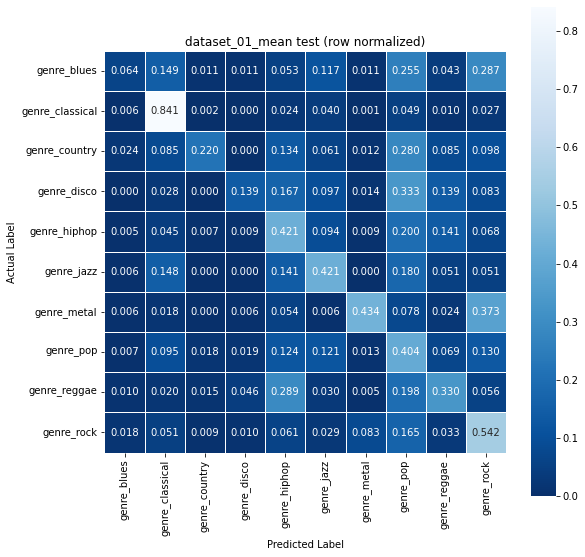



Dataset: ../../../datasets/dataset_02_mean_cov.pickle

Train: train_accuracy = 0.996136

                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.9973  1.0000    0.9987      374  0.9986
  genre_classical     0.9979  0.9974    0.9976     4221  0.9969
    genre_country     1.0000  1.0000    1.0000      327  1.0000
      genre_disco     1.0000  1.0000    1.0000      289  1.0000
     genre_hiphop     0.9959  1.0000    0.9979     1701  0.9977
       genre_jazz     0.9952  0.9992    0.9972     1241  0.9970
      genre_metal     1.0000  1.0000    1.0000      665  1.0000
        genre_pop     0.9965  0.9890    0.9927     4274  0.9903
     genre_reggae     0.9987  1.0000    0.9994      788  0.9993
       genre_rock     0.9916  0.9978    0.9947     3200  0.9935
                                                               
         accuracy                       0.9961    17080  0.9953
        macro

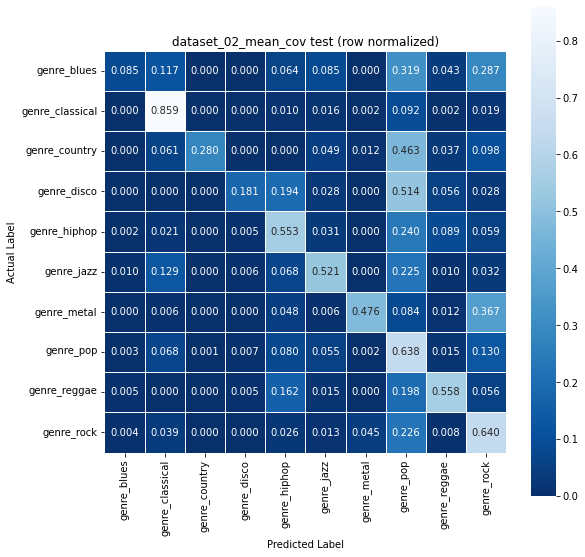



Dataset: ../../../datasets/dataset_03_mean_icov.pickle

Train: train_accuracy = 0.996194

                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.9947  1.0000    0.9973      374  0.9973
  genre_classical     0.9920  0.9976    0.9948     4221  0.9931
    genre_country     1.0000  1.0000    1.0000      327  1.0000
      genre_disco     1.0000  1.0000    1.0000      289  1.0000
     genre_hiphop     0.9982  1.0000    0.9991     1701  0.9990
       genre_jazz     0.9976  0.9992    0.9984     1241  0.9983
      genre_metal     1.0000  1.0000    1.0000      665  1.0000
        genre_pop     0.9972  0.9892    0.9932     4274  0.9909
     genre_reggae     1.0000  1.0000    1.0000      788  1.0000
       genre_rock     0.9966  0.9975    0.9970     3200  0.9963
                                                               
         accuracy                       0.9962    17080  0.9954
        macr

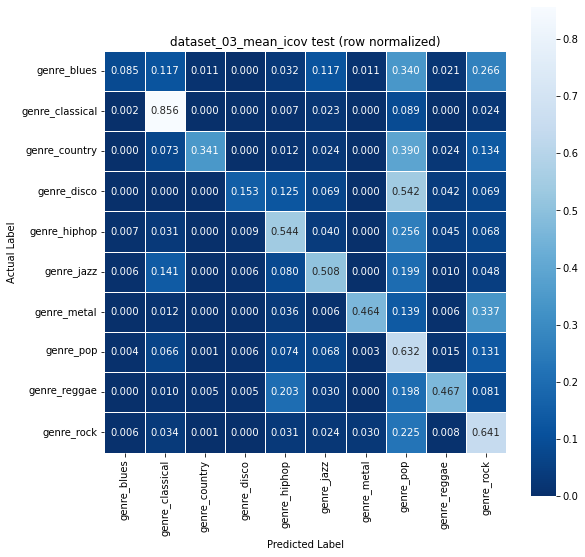



Dataset: ../../../datasets/dataset_04_mean_cov_icov.pickle

Train: train_accuracy = 0.999122

                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.9973  1.0000    0.9987      374  0.9986
  genre_classical     0.9993  0.9995    0.9994     4221  0.9992
    genre_country     1.0000  1.0000    1.0000      327  1.0000
      genre_disco     1.0000  1.0000    1.0000      289  1.0000
     genre_hiphop     0.9988  1.0000    0.9994     1701  0.9993
       genre_jazz     1.0000  0.9992    0.9996     1241  0.9996
      genre_metal     1.0000  1.0000    1.0000      665  1.0000
        genre_pop     0.9998  0.9974    0.9986     4274  0.9981
     genre_reggae     1.0000  1.0000    1.0000      788  1.0000
       genre_rock     0.9975  0.9997    0.9986     3200  0.9983
                                                               
         accuracy                       0.9991    17080  0.9989
        

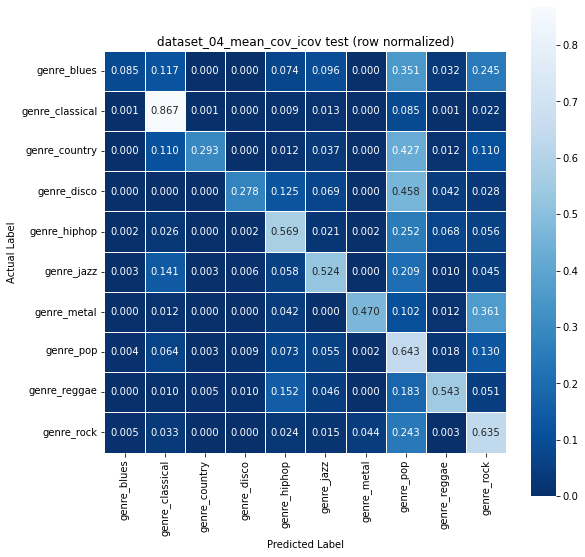



Dataset: ../../../datasets/dataset_05_pvtt.pickle

Train: train_accuracy = 0.825234

                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.7435  1.0000    0.8529      374  0.8590
  genre_classical     0.9398  0.9209    0.9302     4221  0.9077
    genre_country     0.7047  1.0000    0.8268      327  0.8360
      genre_disco     0.8006  1.0000    0.8892      289  0.8928
     genre_hiphop     0.7538  0.8983    0.8197     1701  0.8017
       genre_jazz     0.6973  0.9670    0.8103     1241  0.8055
      genre_metal     0.8240  1.0000    0.9035      665  0.9038
        genre_pop     0.8804  0.6270    0.7324     4274  0.6775
     genre_reggae     0.6477  0.9987    0.7858      788  0.7936
       genre_rock     0.8415  0.7369    0.7857     3200  0.7427
                                                               
         accuracy                       0.8252    17080  0.7955
        macro avg

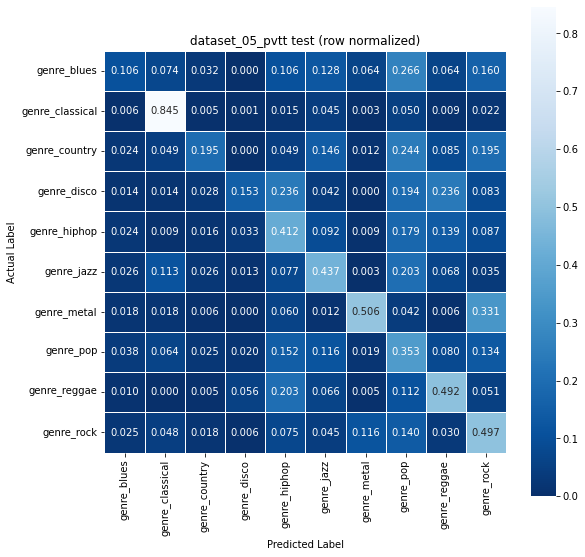



Dataset: ../../../datasets/dataset_06_pvtt_mean.pickle

Train: train_accuracy = 0.944731

                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.9664  1.0000    0.9829      374  0.9827
  genre_classical     0.9823  0.9709    0.9765     4221  0.9689
    genre_country     0.9703  1.0000    0.9849      327  0.9848
      genre_disco     0.9797  1.0000    0.9897      289  0.9896
     genre_hiphop     0.9013  0.9929    0.9449     1701  0.9398
       genre_jazz     0.8736  0.9968    0.9311     1241  0.9277
      genre_metal     0.9837  1.0000    0.9918      665  0.9915
        genre_pop     0.9557  0.8636    0.9073     4274  0.8804
     genre_reggae     0.9110  1.0000    0.9534      788  0.9522
       genre_rock     0.9318  0.9306    0.9312     3200  0.9154
                                                               
         accuracy                       0.9447    17080  0.9336
        macr

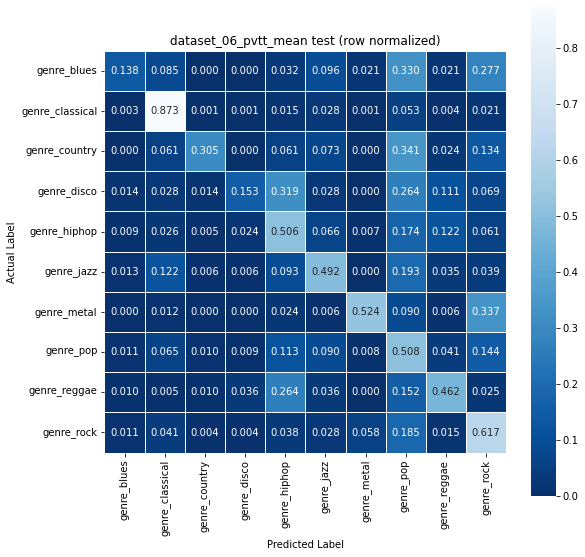



Dataset: ../../../datasets/dataset_07_pvtt_mean_cov.pickle

Train: train_accuracy = 0.998478

                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      374  1.0000
  genre_classical     0.9993  0.9995    0.9994     4221  0.9992
    genre_country     1.0000  1.0000    1.0000      327  1.0000
      genre_disco     1.0000  1.0000    1.0000      289  1.0000
     genre_hiphop     0.9982  1.0000    0.9991     1701  0.9990
       genre_jazz     0.9984  1.0000    0.9992     1241  0.9991
      genre_metal     1.0000  1.0000    1.0000      665  1.0000
        genre_pop     0.9995  0.9946    0.9971     4274  0.9961
     genre_reggae     1.0000  1.0000    1.0000      788  1.0000
       genre_rock     0.9950  0.9997    0.9973     3200  0.9967
                                                               
         accuracy                       0.9985    17080  0.9981
        

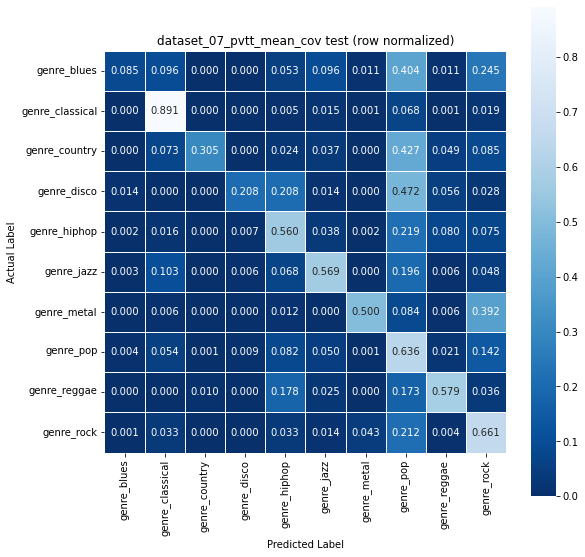



Dataset: ../../../datasets/dataset_08_pvtt_mean_icov.pickle

Train: train_accuracy = 0.997658

                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      374  1.0000
  genre_classical     0.9953  0.9988    0.9970     4221  0.9961
    genre_country     1.0000  1.0000    1.0000      327  1.0000
      genre_disco     1.0000  1.0000    1.0000      289  1.0000
     genre_hiphop     0.9982  1.0000    0.9991     1701  0.9990
       genre_jazz     0.9992  1.0000    0.9996     1241  0.9996
      genre_metal     1.0000  1.0000    1.0000      665  1.0000
        genre_pop     0.9988  0.9930    0.9959     4274  0.9945
     genre_reggae     1.0000  1.0000    1.0000      788  1.0000
       genre_rock     0.9966  0.9984    0.9975     3200  0.9969
                                                               
         accuracy                       0.9977    17080  0.9972
       

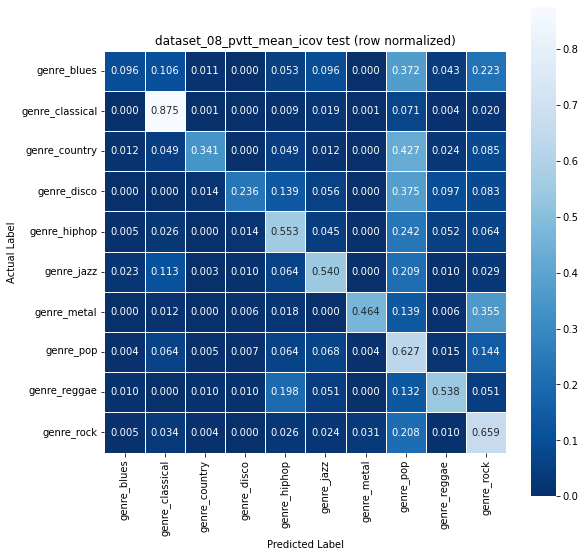



Dataset: ../../../datasets/dataset_09_pvtt_mean_cov_icov.pickle

Train: train_accuracy = 0.999532

                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  1.0000    1.0000      374  1.0000
  genre_classical     0.9998  0.9998    0.9998     4221  0.9997
    genre_country     1.0000  1.0000    1.0000      327  1.0000
      genre_disco     1.0000  1.0000    1.0000      289  1.0000
     genre_hiphop     0.9988  1.0000    0.9994     1701  0.9993
       genre_jazz     1.0000  1.0000    1.0000     1241  1.0000
      genre_metal     1.0000  1.0000    1.0000      665  1.0000
        genre_pop     1.0000  0.9984    0.9992     4274  0.9989
     genre_reggae     1.0000  1.0000    1.0000      788  1.0000
       genre_rock     0.9984  1.0000    0.9992     3200  0.9990
                                                               
         accuracy                       0.9995    17080  0.9994
   

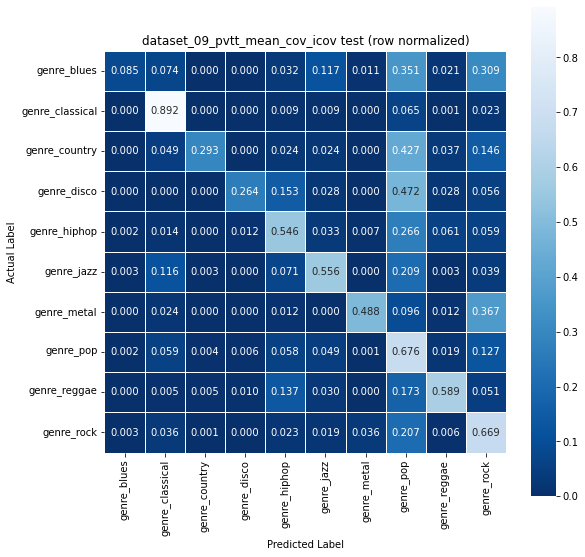



Dataset: ../../../datasets/dataset_10_melspecs_flattened.pickle

Train: train_accuracy = 0.999239

                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.9973  1.0000    0.9987      374  0.9986
  genre_classical     0.9995  0.9993    0.9994     4221  0.9992
    genre_country     1.0000  1.0000    1.0000      327  1.0000
      genre_disco     1.0000  1.0000    1.0000      289  1.0000
     genre_hiphop     0.9988  0.9994    0.9991     1701  0.9990
       genre_jazz     1.0000  0.9992    0.9996     1241  0.9996
      genre_metal     1.0000  1.0000    1.0000      665  1.0000
        genre_pop     1.0000  0.9981    0.9991     4274  0.9988
     genre_reggae     0.9949  1.0000    0.9975      788  0.9973
       genre_rock     0.9988  1.0000    0.9994     3200  0.9992
                                                               
         accuracy                       0.9992    17080  0.9991
   

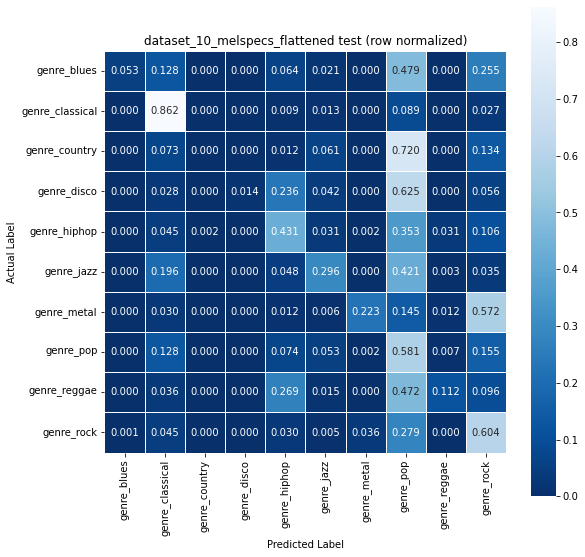

In [3]:
dataset_folder = "../../../datasets/"
datasets = sorted([name for name in glob.glob(dataset_folder + "dataset_*.pickle")])
for dataset in datasets:
    cross_gradient_boost_experiment(dataset)